[Zero-shot Whisper ENS] load_air_passengers | H=24 | MAE=165.74 RMSE=173.81 MAPE=36.25% R²=-4.4170 | α=0.25 win=48 secs=4 seeds×pool=8×2


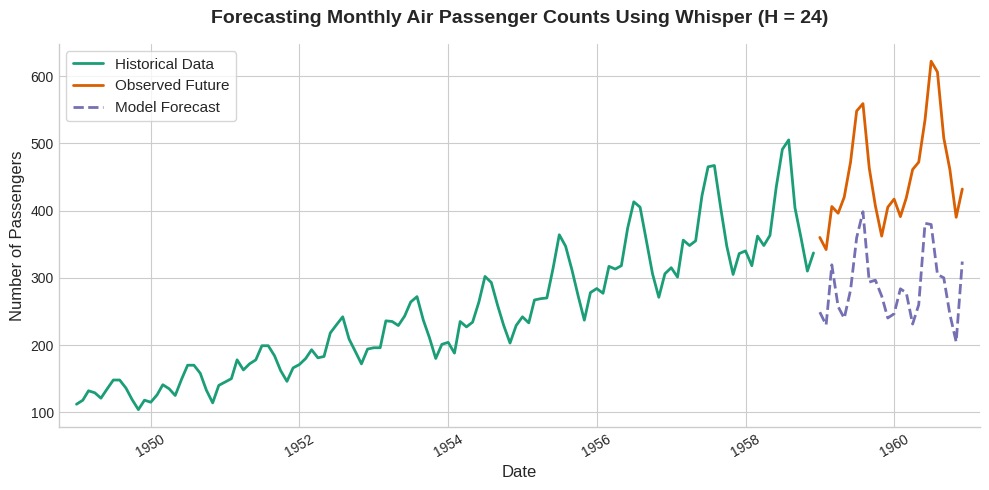

{'load_air_passengers': {'horizon': 24, 'MAE': 165.74, 'RMSE': 173.81, 'MAPE (%)': np.float32(36.25), 'R²': np.float32(-4.417)}}


In [ ]:
# ========================== ZERO-SHOT WHISPER (ENSEMBLE+PRIOR) ==========================
import math, numpy as np, pandas as pd, matplotlib.pyplot as plt, torch, torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from transformers import WhisperModel, WhisperFeatureExtractor

# --- If you already created RESULTS/log_simple_result earlier, keep them. Otherwise:
try:
    RESULTS
except NameError:
    RESULTS = {}
def log_simple_result(results_dict, dataset_name, horizon, mae, rmse, mape, r2):
    results_dict[dataset_name] = {
        "horizon": horizon, "MAE": round(mae,2), "RMSE": round(rmse,2),
        "MAPE (%)": round(mape,2), "R²": round(r2,4)
    }

# --- Whisper (load once if not already in memory)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
try:
    whisper, feat_extractor
except NameError:
    WHISPER_ID = "openai/whisper-small"
    whisper = WhisperModel.from_pretrained(WHISPER_ID).to(device).eval()
    for p in whisper.parameters(): p.requires_grad = False
    feat_extractor = WhisperFeatureExtractor.from_pretrained(WHISPER_ID)

# --- Helpers (deterministic, no training)
def series_window_to_waveform(window_1d: np.ndarray, out_len: int = 16000) -> np.ndarray:
    w = np.asarray(window_1d, dtype=np.float32).reshape(-1)
    if w.size < 2: w = np.pad(w, (0, 2-w.size), mode="edge")
    w_min, w_max = float(w.min()), float(w.max())
    if w_max > w_min: w01 = (w - w_min) / (w_max - w_min)
    else: w01 = np.zeros_like(w)
    wpm = (w01 * 2.0 - 1.0).astype(np.float32)
    src_x = np.linspace(0, 1, num=wpm.size, dtype=np.float32)
    dst_x = np.linspace(0, 1, num=out_len, dtype=np.float32)
    return np.interp(dst_x, src_x, wpm).astype(np.float32)

class FixedRandomReadout(nn.Module):
    def __init__(self, in_dim: int, horizon: int, seed: int = 1234):
        super().__init__()
        rng = np.random.default_rng(seed)
        W = rng.standard_normal((in_dim, horizon)).astype(np.float32) / np.sqrt(in_dim)
        b = np.zeros((horizon,), dtype=np.float32)
        # Ensure tensors are float32
        self.register_buffer("W", torch.from_numpy(W).float())
        self.register_buffer("b", torch.from_numpy(b).float())
    def forward(self, x):  # x: (B, H)
        return x @ self.W + self.b

def whisper_zeroshot_prediction(
    dataset,
    horizon=12,
    frequency="M",
    dataset_name=None,
    results_dict=RESULTS,
    # --- stability knobs (no training) ---
    window_size=48,                 # months of context
    waveform_seconds=4,             # longer pseudo-audio -> more frames
    sampling_rate=16000,
    seed_list=(3,7,19,23,29,31,37,41),   # ensemble readouts
    pooling_list=("mean","last"),        # ensemble poolings
    alpha=0.25,                      # weight on Whisper vs seasonal-naive
    log_transform=True,              # stabilize multiplicative growth
    clamp_factor=1.5,                # cap to 1.5x max(train)
    verbose=True,
):
    # 1) Load dataset
    train_df, test_df = dataset(horizon=horizon)
    y_train_raw = train_df["y"].values.astype(np.float32)
    y_test_raw  = test_df["y"].values.astype(np.float32)
    name = dataset_name or getattr(dataset, "__name__", "unnamed_dataset")

    # 2) Optional log transform
    if log_transform:
        y_train = np.log1p(y_train_raw)
        y_test  = np.log1p(y_test_raw)
    else:
        y_train = y_train_raw.copy()
        y_test  = y_test_raw.copy()

    # 3) Train-only scaling
    scaler = MinMaxScaler()
    y_train_s = scaler.fit_transform(y_train.reshape(-1,1)).flatten()
    if len(y_train_s) < window_size:
        raise ValueError(f"len(train)={len(y_train_s)} < window_size={window_size}")

    # 4) Pseudo-audio
    wav_len = int(waveform_seconds * sampling_rate)
    wav = series_window_to_waveform(y_train_s[-window_size:], out_len=wav_len)

    with torch.no_grad():
        mel = feat_extractor(wav[None,:], sampling_rate=sampling_rate, return_tensors="pt").input_features.to(device)
        enc = whisper.encoder(mel).last_hidden_state  # (1, L, H)

    # 5) Ensemble zero-shot readouts
    preds_s = []
    for pooling in pooling_list:
        pooled = enc[:, -1, :] if pooling == "last" else enc.mean(dim=1)  # (1,H)
        H = pooled.shape[-1]
        for seed in seed_list:
            head = FixedRandomReadout(in_dim=H, horizon=horizon, seed=seed).to(device)
            with torch.no_grad():
                preds_s.append(head(pooled).squeeze(0).cpu().numpy())
    whisper_pred_s = np.mean(np.stack(preds_s, axis=0), axis=0)               # (H,)
    whisper_pred   = scaler.inverse_transform(whisper_pred_s.reshape(-1,1)).flatten()

    # 6) Seasonal-naive prior (+ simple drift), still zero-shot
    season = 12 if frequency.upper().startswith("M") else max(1, min(7, len(y_train)))
    if len(y_train) >= season:
        rep = int(np.ceil(horizon / season))
        last_season = y_train[-season:]
        seasonal = np.tile(last_season, rep)[:horizon]
        if len(y_train) >= 2*season:
            prev_season = y_train[-2*season:-season]
            drift_step = (last_season.mean() - prev_season.mean()) / season
        else:
            drift_step = 0.0
        drift = np.arange(1, horizon+1, dtype=np.float32) * drift_step
        seasonal_naive = seasonal + drift
    else:
        seasonal_naive = np.full(horizon, y_train[-1], dtype=np.float32)

    # 7) Blend & invert log if needed
    blended = alpha * whisper_pred + (1 - alpha) * seasonal_naive
    if log_transform:
        y_pred = np.expm1(blended); y_true = y_test_raw
    else:
        y_pred = blended; y_true = y_test_raw

    # 8) Clamp to plausible range (avoid negatives/huge spikes)
    y_pred = np.clip(y_pred, 0.0, float(np.max(y_train_raw) * clamp_factor))

    # 9) Metrics
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    with np.errstate(divide="ignore", invalid="ignore"):
        mape = np.nanmean(np.abs((y_true - y_pred) / y_true) * 100.0)
        if np.isnan(mape): mape = float("inf")
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    r2 = 1 - ss_res / ss_tot if ss_tot != 0 else float("nan")
    log_simple_result(results_dict, name, horizon, mae, rmse, mape, r2)

    if verbose:
        print(f"[Zero-shot Whisper ENS] {name} | H={horizon} | "
              f"MAE={mae:.2f} RMSE={rmse:.2f} MAPE={mape:.2f}% R²={r2:.4f} | "
              f"α={alpha} win={window_size} secs={waveform_seconds} seeds×pool={len(seed_list)}×{len(pooling_list)}")

    # 10) Plot
     # Colorblind-friendly palette
    history_color = '#1b9e77'   # teal
    observed_color = '#d95f02'  # muted orange
    forecast_color = '#7570b3'  # muted purple

    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(10, 5))

    ax.plot(train_df['ds'], train_df['y'], label="Historical Data",
            color=history_color, linewidth=2)
    ax.plot(test_df['ds'], y_true, label="Observed Future",
            color=observed_color, markersize=6, linewidth=2)
    ax.plot(test_df['ds'], y_pred, label="Model Forecast",
            color=forecast_color, markersize=6, linewidth=2, linestyle='--')

    ax.set_title(f"Forecasting Monthly Air Passenger Counts Using Whisper (H = {horizon})",
                 fontsize=14, fontweight='bold', pad=15)
    ax.set_xlabel("Date", fontsize=12)
    ax.set_ylabel("Number of Passengers", fontsize=12)

    ax.legend(fontsize=11, frameon=True, loc='upper left')
    ax.tick_params(axis='x', rotation=30)
    ax.margins(x=0.02)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.savefig('Whisper', dpi=300)
    plt.show()

# ---------------- Example dataset loader (AirPassengers) ----------------
def load_air_passengers(horizon=12, unique_id="AP1"):
    url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
    df = pd.read_csv(url)
    df["Month"] = pd.to_datetime(df["Month"])
    df = df.rename(columns={"Month": "ds", "Passengers": "y"})
    train_df = df.iloc[:-horizon].copy(); test_df = df.iloc[-horizon:].copy()
    train_df["unique_id"] = unique_id; test_df["unique_id"] = unique_id
    return train_df[["unique_id","ds","y"]], test_df[["unique_id","ds","y"]]

# --------------------------- Run it ------------------------------------
whisper_zeroshot_prediction(
    load_air_passengers,
    horizon=24,
    frequency="M",
    window_size=48,
    waveform_seconds=4,
    seed_list=(3,7,19,23,29,31,37,41),
    pooling_list=("mean","last"),
    alpha=0.25,
    log_transform=True,
    clamp_factor=1.5,
    verbose=True,
)
print(RESULTS)

(3265, 2)
Mean:  81.77877488514548
[Zero-shot Whisper ENS] load_air_sunsopts | H=120 | MAE=423.16 RMSE=477.02 MAPE=14481.10% R²=-127.2336 | α=0.25 win=48 secs=4 seeds×pool=8×2


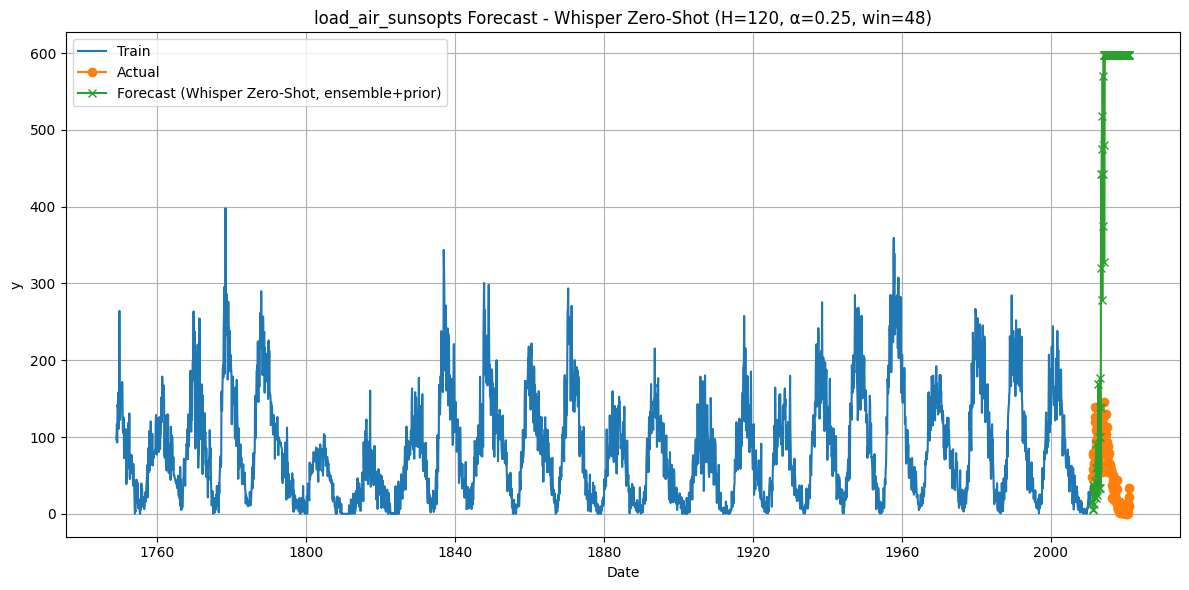

{'load_air_passengers': {'horizon': 24,
  'MAE': 165.74,
  'RMSE': 173.81,
  'MAPE (%)': np.float32(36.25),
  'R²': np.float32(-4.417)},
 'load_air_sunsopts': {'horizon': 120,
  'MAE': 423.16,
  'RMSE': 477.02,
  'MAPE (%)': np.float32(14481.1),
  'R²': np.float32(-127.2336)},
 'load_temp': {'horizon': 24,
  'MAE': 4.36,
  'RMSE': 5.37,
  'MAPE (%)': np.float32(31.85),
  'R²': np.float32(-10.4322)}}

In [ ]:
def load_air_sunsopts(horizon=24, unique_id="AP1"):

    url = "https://raw.githubusercontent.com/ahamed14051/time-series-dataset/refs/heads/main/Sunspots.csv"
    df = pd.read_csv(url)
    df = df.drop(columns=['Unnamed: 0'])
    print(df.shape)

    # Standardize column names
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.rename(columns={"Date": "ds", "Monthly Mean Total Sunspot Number": "y"})
    print('Mean: ', df['y'].mean())

    # Split train/test
    train_df = df.iloc[:-horizon].copy()
    test_df = df.iloc[-horizon:].copy()

    # Add unique_id
    train_df['unique_id'] = unique_id
    test_df['unique_id'] = unique_id

    return train_df[['unique_id', 'ds', 'y']], test_df[['unique_id', 'ds', 'y']]

whisper_zeroshot_prediction(
    load_air_sunsopts,
    horizon=120,
    frequency="M",
    window_size=48,
    waveform_seconds=4,
    seed_list=(3,7,19,23,29,31,37,41),
    pooling_list=("mean","last"),
    alpha=0.25,
    log_transform=True,
    clamp_factor=1.5,
    verbose=True,
)

Mean: 11.186646558815465
[Zero-shot Whisper ENS] load_temp | H=240 | MAE=12.12 RMSE=15.07 MAPE=126.02% R²=-18.9180 | α=0.25 win=48 secs=4 seeds×pool=8×2


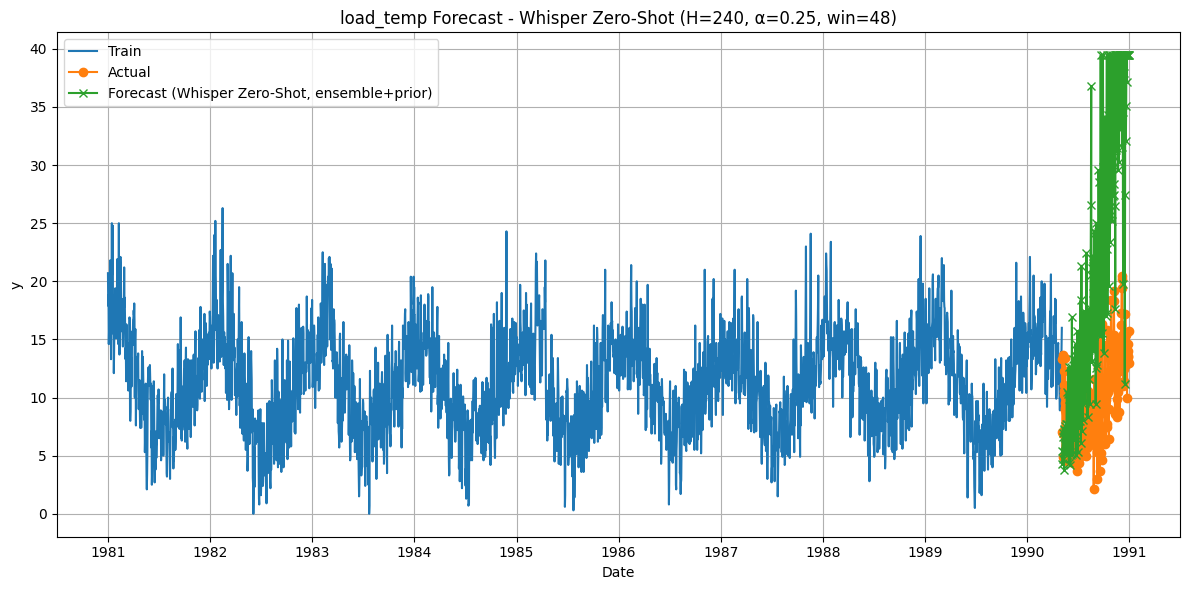

{'load_air_passengers': {'horizon': 24,
  'MAE': 165.74,
  'RMSE': 173.81,
  'MAPE (%)': np.float32(36.25),
  'R²': np.float32(-4.417)},
 'load_air_sunsopts': {'horizon': 120,
  'MAE': 423.16,
  'RMSE': 477.02,
  'MAPE (%)': np.float32(14481.1),
  'R²': np.float32(-127.2336)},
 'load_temp': {'horizon': 240,
  'MAE': 12.12,
  'RMSE': 15.07,
  'MAPE (%)': np.float32(126.02),
  'R²': np.float32(-18.918)}}

In [ ]:
def load_temp(horizon=24, unique_id="AP1"):
    df = pd.read_csv("https://raw.githubusercontent.com/ahamed14051/time-series-dataset/refs/heads/main/temp.csv")

    # Remove unnamed columns
    if 'Unnamed: 2' in df.columns:
        df = df.drop(columns=['Unnamed: 2'])

    # Parse date safely
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

    # Drop rows with invalid dates (like the description text)
    df = df.dropna(subset=['Date'])

    # Rename columns
    df = df.rename(columns={"Date": "ds", "temp": "y"})

    # Convert 'y' to numeric, coercing errors to NaN and dropping them
    df['y'] = pd.to_numeric(df['y'], errors='coerce')
    df = df.dropna(subset=['y'])

    print('Mean:', df['y'].mean())

    # Train/test split
    train_df = df.iloc[:-horizon].copy()
    test_df = df.iloc[-horizon:].copy()

    # Add unique_id
    train_df['unique_id'] = unique_id
    test_df['unique_id'] = unique_id

    return train_df[['unique_id', 'ds', 'y']], test_df[['unique_id', 'ds', 'y']]

whisper_zeroshot_prediction(
    load_temp,
    horizon=240,
    frequency="D",
    window_size=48,
    waveform_seconds=4,
    seed_list=(3,7,19,23,29,31,37,41),
    pooling_list=("mean","last"),
    alpha=0.25,
    log_transform=True,
    clamp_factor=1.5,
    verbose=True,
)

Mean Temperature: 16.317261904761903
[Zero-shot Whisper ENS] load_temperature | H=24 | MAE=4.55 RMSE=5.79 MAPE=24.50% R²=0.3146 | α=0.25 win=48 secs=4 seeds×pool=8×2


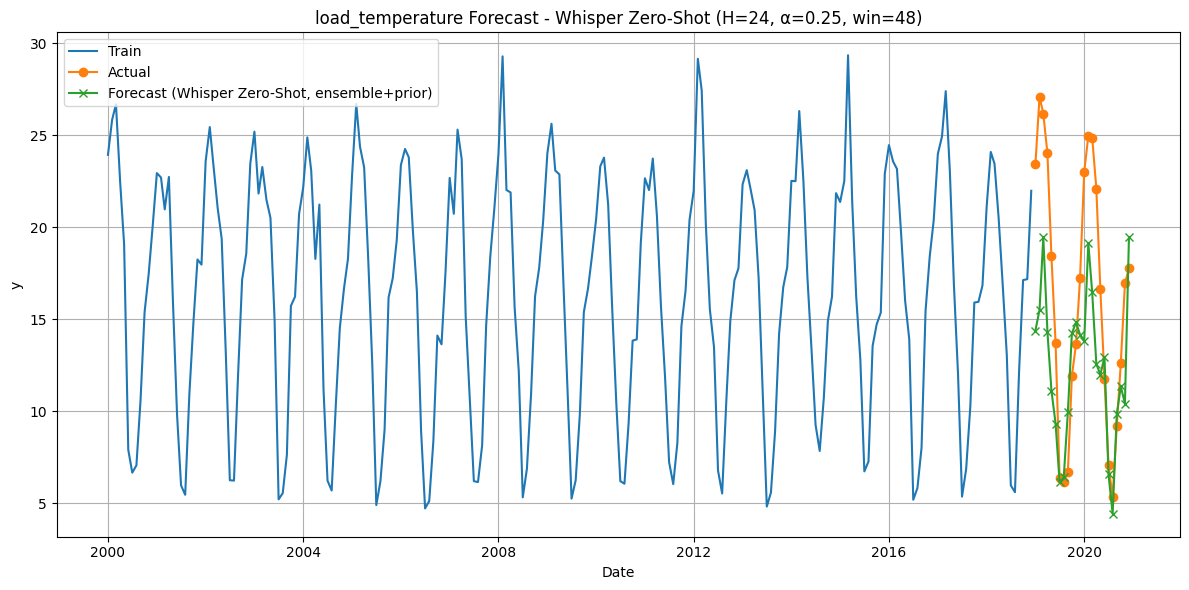

{'load_air_passengers': {'horizon': 24,
  'MAE': 165.74,
  'RMSE': 173.81,
  'MAPE (%)': np.float32(36.25),
  'R²': np.float32(-4.417)},
 'load_air_sunsopts': {'horizon': 120,
  'MAE': 423.16,
  'RMSE': 477.02,
  'MAPE (%)': np.float32(14481.1),
  'R²': np.float32(-127.2336)},
 'load_temp': {'horizon': 240,
  'MAE': 12.12,
  'RMSE': 15.07,
  'MAPE (%)': np.float32(126.02),
  'R²': np.float32(-18.918)},
 'load_temperature': {'horizon': 24,
  'MAE': 4.55,
  'RMSE': 5.79,
  'MAPE (%)': np.float32(24.5),
  'R²': np.float32(0.3146)}}

In [ ]:
def load_temperature(horizon=24, unique_id="AP1"):
    # Load the dataset
    df = pd.read_csv("https://raw.githubusercontent.com/ahamed14051/time-series-dataset/refs/heads/main/Rainfall_data.csv")

    # Create timestamp from Year, Month, Day
    df['ds'] = pd.to_datetime(df[['Year', 'Month', 'Day']])

    # Use Temperature column as 'y'
    df['y'] = pd.to_numeric(df['Temperature'], errors='coerce')
    df = df.dropna(subset=['y'])

    print('Mean Temperature:', df['y'].mean())

    # Train/test split
    train_df = df.iloc[:-horizon].copy()
    test_df = df.iloc[-horizon:].copy()

    # Add unique_id
    train_df['unique_id'] = unique_id
    test_df['unique_id'] = unique_id

    return train_df[['unique_id', 'ds', 'y']], test_df[['unique_id', 'ds', 'y']]

whisper_zeroshot_prediction(
    load_temperature,
    horizon=24,
    frequency="M",
    window_size=48,
    waveform_seconds=4,
    seed_list=(3,7,19,23,29,31,37,41),
    pooling_list=("mean","last"),
    alpha=0.25,
    log_transform=True,
    clamp_factor=1.5,
    verbose=True,
)

Mean Precipitation: 206.79892857142858
[Zero-shot Whisper ENS] load_precipitation | H=24 | MAE=229.10 RMSE=406.67 MAPE=248.94% R²=-0.1498 | α=0.25 win=48 secs=4 seeds×pool=8×2


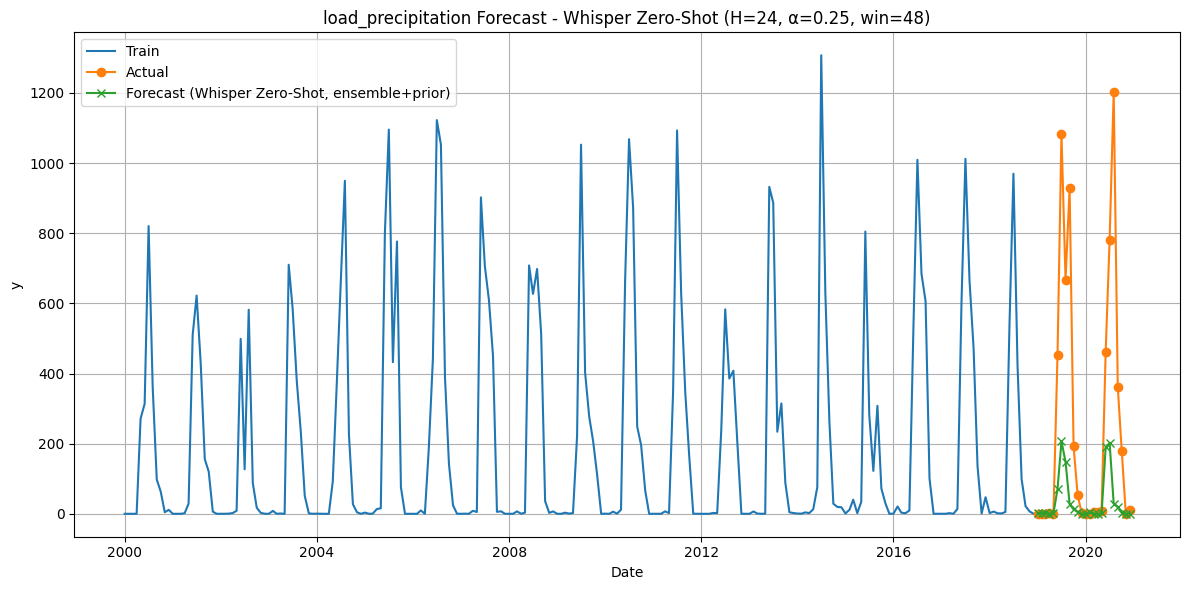

{'load_air_passengers': {'horizon': 24,
  'MAE': 165.74,
  'RMSE': 173.81,
  'MAPE (%)': np.float32(36.25),
  'R²': np.float32(-4.417)},
 'load_air_sunsopts': {'horizon': 120,
  'MAE': 423.16,
  'RMSE': 477.02,
  'MAPE (%)': np.float32(14481.1),
  'R²': np.float32(-127.2336)},
 'load_temp': {'horizon': 240,
  'MAE': 12.12,
  'RMSE': 15.07,
  'MAPE (%)': np.float32(126.02),
  'R²': np.float32(-18.918)},
 'load_temperature': {'horizon': 24,
  'MAE': 4.55,
  'RMSE': 5.79,
  'MAPE (%)': np.float32(24.5),
  'R²': np.float32(0.3146)},
 'load_precipitation': {'horizon': 24,
  'MAE': 229.1,
  'RMSE': 406.67,
  'MAPE (%)': np.float32(248.94),
  'R²': np.float32(-0.1498)}}

In [ ]:
def load_precipitation(horizon=24, unique_id="AP1"):
    # Load the dataset
    df = pd.read_csv("https://raw.githubusercontent.com/ahamed14051/time-series-dataset/refs/heads/main/Rainfall_data.csv")

    # Create timestamp from Year, Month, Day
    df['ds'] = pd.to_datetime(df[['Year', 'Month', 'Day']])

    # Use Temperature column as 'y'
    df['y'] = pd.to_numeric(df['Precipitation'], errors='coerce')
    df = df.dropna(subset=['y'])

    print('Mean Precipitation:', df['y'].mean())

    # Train/test split
    train_df = df.iloc[:-horizon].copy()
    test_df = df.iloc[-horizon:].copy()

    # Add unique_id
    train_df['unique_id'] = unique_id
    test_df['unique_id'] = unique_id

    return train_df[['unique_id', 'ds', 'y']], test_df[['unique_id', 'ds', 'y']]

whisper_zeroshot_prediction(
    load_precipitation,
    horizon=24,
    frequency="M",
    window_size=48,
    waveform_seconds=4,
    seed_list=(3,7,19,23,29,31,37,41),
    pooling_list=("mean","last"),
    alpha=0.25,
    log_transform=True,
    clamp_factor=1.5,
    verbose=True,
)

Mean Specific Humidity: 14.416746031746033
[Zero-shot Whisper ENS] load_humidity | H=24 | MAE=4.06 RMSE=4.54 MAPE=26.08% R²=-0.0414 | α=0.25 win=48 secs=4 seeds×pool=8×2


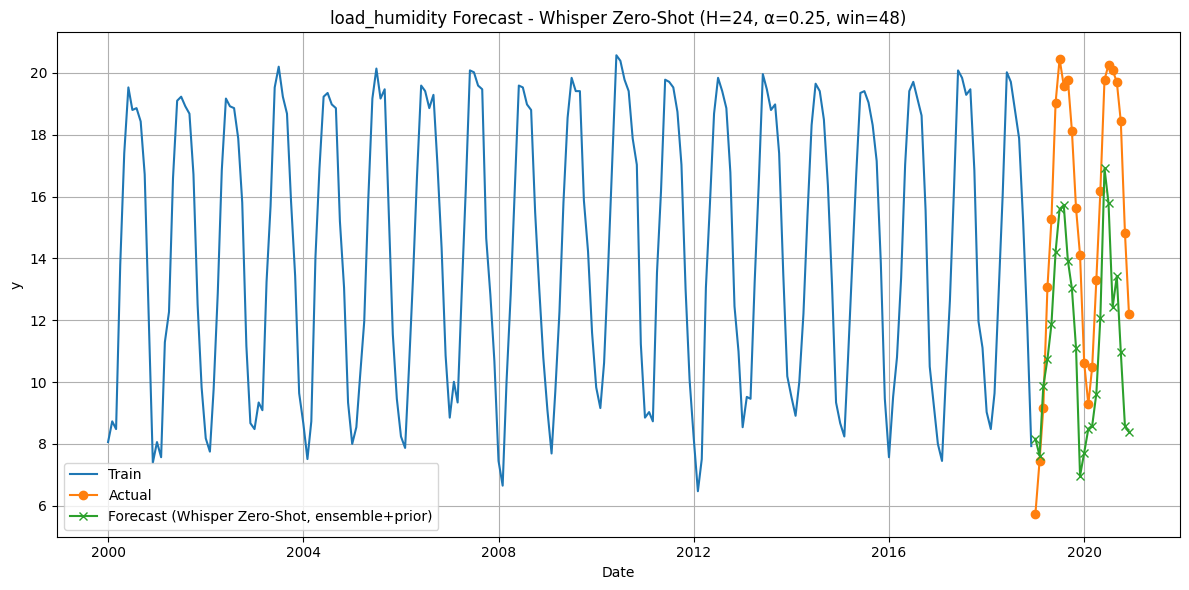

{'load_air_passengers': {'horizon': 24,
  'MAE': 165.74,
  'RMSE': 173.81,
  'MAPE (%)': np.float32(36.25),
  'R²': np.float32(-4.417)},
 'load_air_sunsopts': {'horizon': 120,
  'MAE': 423.16,
  'RMSE': 477.02,
  'MAPE (%)': np.float32(14481.1),
  'R²': np.float32(-127.2336)},
 'load_temp': {'horizon': 240,
  'MAE': 12.12,
  'RMSE': 15.07,
  'MAPE (%)': np.float32(126.02),
  'R²': np.float32(-18.918)},
 'load_temperature': {'horizon': 24,
  'MAE': 4.55,
  'RMSE': 5.79,
  'MAPE (%)': np.float32(24.5),
  'R²': np.float32(0.3146)},
 'load_precipitation': {'horizon': 24,
  'MAE': 229.1,
  'RMSE': 406.67,
  'MAPE (%)': np.float32(248.94),
  'R²': np.float32(-0.1498)},
 'load_humidity': {'horizon': 24,
  'MAE': 4.06,
  'RMSE': 4.54,
  'MAPE (%)': np.float32(26.08),
  'R²': np.float32(-0.0414)}}

In [ ]:
def load_humidity(horizon=24, unique_id="AP1"):
    # Load the dataset
    df = pd.read_csv("https://raw.githubusercontent.com/ahamed14051/time-series-dataset/refs/heads/main/Rainfall_data.csv")

    # Create timestamp from Year, Month, Day
    df['ds'] = pd.to_datetime(df[['Year', 'Month', 'Day']])

    # Use Temperature column as 'y'
    df['y'] = pd.to_numeric(df['Specific Humidity'], errors='coerce')
    df = df.dropna(subset=['y'])

    print('Mean Specific Humidity:', df['y'].mean())

    # Train/test split
    train_df = df.iloc[:-horizon].copy()
    test_df = df.iloc[-horizon:].copy()

    # Add unique_id
    train_df['unique_id'] = unique_id
    test_df['unique_id'] = unique_id

    return train_df[['unique_id', 'ds', 'y']], test_df[['unique_id', 'ds', 'y']]

whisper_zeroshot_prediction(
    load_humidity,
    horizon=24,
    frequency="M",
    window_size=48,
    waveform_seconds=4,
    seed_list=(3,7,19,23,29,31,37,41),
    pooling_list=("mean","last"),
    alpha=0.25,
    log_transform=True,
    clamp_factor=1.5,
    verbose=True,
)

Mean Relative Humidity: 67.25952380952381
[Zero-shot Whisper ENS] load_relative_humidity | H=24 | MAE=16.91 RMSE=19.54 MAPE=23.14% R²=-0.1582 | α=0.25 win=48 secs=4 seeds×pool=8×2


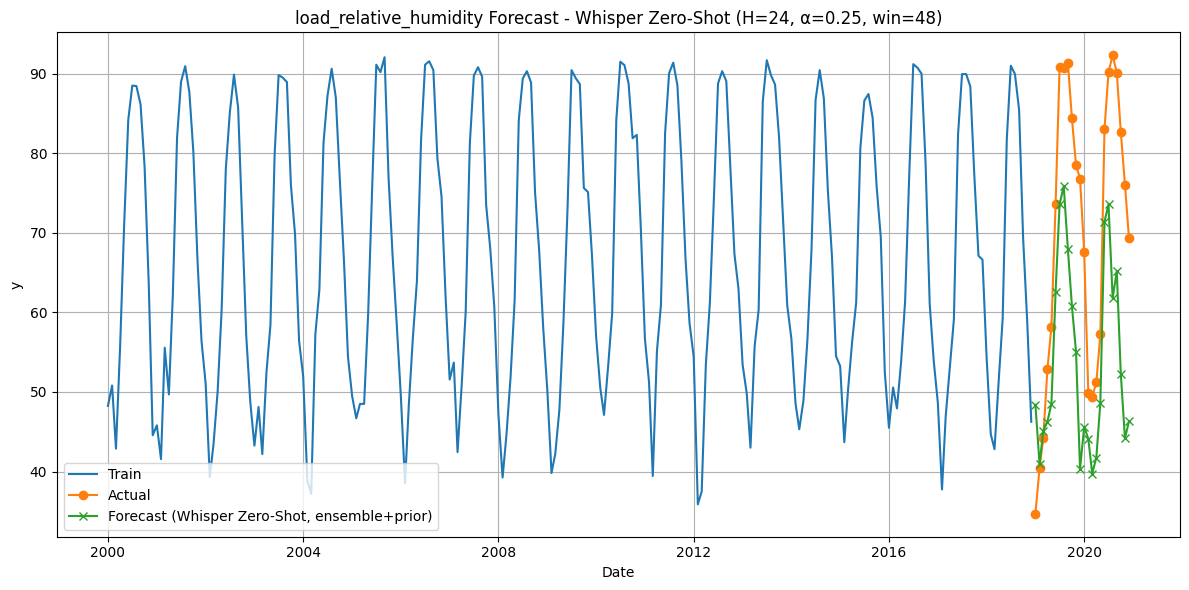

{'load_air_passengers': {'horizon': 24,
  'MAE': 165.74,
  'RMSE': 173.81,
  'MAPE (%)': np.float32(36.25),
  'R²': np.float32(-4.417)},
 'load_air_sunsopts': {'horizon': 120,
  'MAE': 423.16,
  'RMSE': 477.02,
  'MAPE (%)': np.float32(14481.1),
  'R²': np.float32(-127.2336)},
 'load_temp': {'horizon': 240,
  'MAE': 12.12,
  'RMSE': 15.07,
  'MAPE (%)': np.float32(126.02),
  'R²': np.float32(-18.918)},
 'load_temperature': {'horizon': 24,
  'MAE': 4.55,
  'RMSE': 5.79,
  'MAPE (%)': np.float32(24.5),
  'R²': np.float32(0.3146)},
 'load_precipitation': {'horizon': 24,
  'MAE': 229.1,
  'RMSE': 406.67,
  'MAPE (%)': np.float32(248.94),
  'R²': np.float32(-0.1498)},
 'load_humidity': {'horizon': 24,
  'MAE': 4.06,
  'RMSE': 4.54,
  'MAPE (%)': np.float32(26.08),
  'R²': np.float32(-0.0414)},
 'load_relative_humidity': {'horizon': 24,
  'MAE': 16.91,
  'RMSE': 19.54,
  'MAPE (%)': np.float32(23.14),
  'R²': np.float32(-0.1582)}}

In [ ]:
def load_relative_humidity(horizon=24, unique_id="AP1"):
    # Load the dataset
    df = pd.read_csv("https://raw.githubusercontent.com/ahamed14051/time-series-dataset/refs/heads/main/Rainfall_data.csv")

    # Create timestamp from Year, Month, Day
    df['ds'] = pd.to_datetime(df[['Year', 'Month', 'Day']])

    # Use Temperature column as 'y'
    df['y'] = pd.to_numeric(df['Relative Humidity'], errors='coerce')
    df = df.dropna(subset=['y'])

    print('Mean Relative Humidity:', df['y'].mean())

    # Train/test split
    train_df = df.iloc[:-horizon].copy()
    test_df = df.iloc[-horizon:].copy()

    # Add unique_id
    train_df['unique_id'] = unique_id
    test_df['unique_id'] = unique_id

    return train_df[['unique_id', 'ds', 'y']], test_df[['unique_id', 'ds', 'y']]

whisper_zeroshot_prediction(
    load_relative_humidity,
    horizon=24,
    frequency="M",
    window_size=48,
    waveform_seconds=4,
    seed_list=(3,7,19,23,29,31,37,41),
    pooling_list=("mean","last"),
    alpha=0.25,
    log_transform=True,
    clamp_factor=1.5,
    verbose=True,
)

Mean: 41.98082191780822
(365, 2)
[Zero-shot Whisper ENS] load_birth | H=24 | MAE=8.21 RMSE=11.32 MAPE=17.30% R²=-2.2035 | α=0.25 win=48 secs=4 seeds×pool=8×2


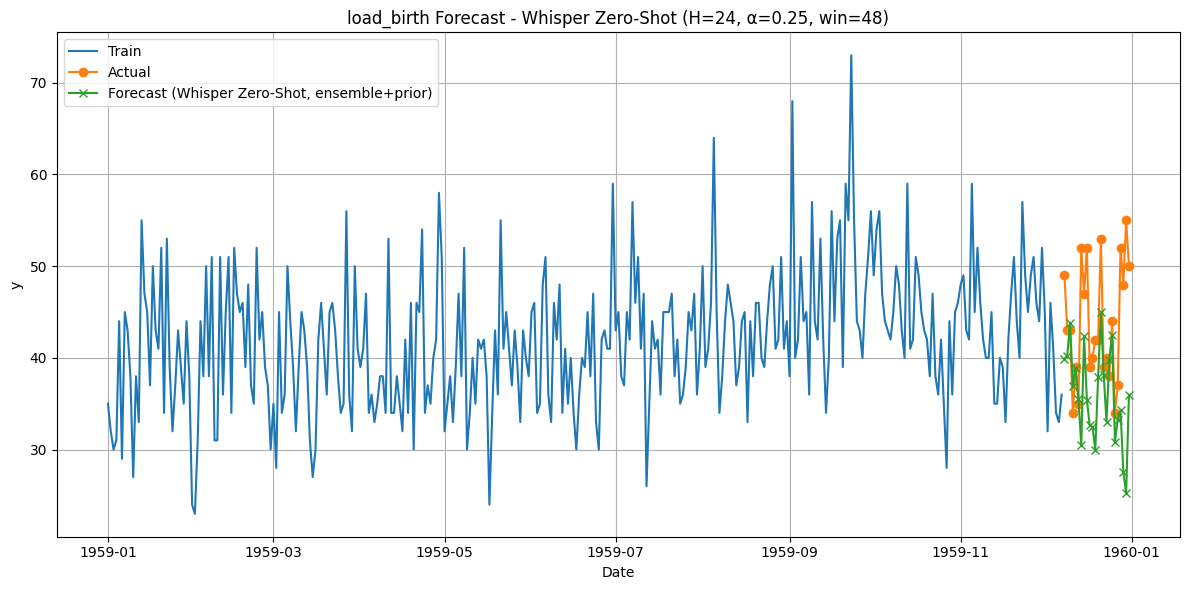

{'load_air_passengers': {'horizon': 24,
  'MAE': 165.74,
  'RMSE': 173.81,
  'MAPE (%)': np.float32(36.25),
  'R²': np.float32(-4.417)},
 'load_air_sunsopts': {'horizon': 120,
  'MAE': 423.16,
  'RMSE': 477.02,
  'MAPE (%)': np.float32(14481.1),
  'R²': np.float32(-127.2336)},
 'load_temp': {'horizon': 240,
  'MAE': 12.12,
  'RMSE': 15.07,
  'MAPE (%)': np.float32(126.02),
  'R²': np.float32(-18.918)},
 'load_temperature': {'horizon': 24,
  'MAE': 4.55,
  'RMSE': 5.79,
  'MAPE (%)': np.float32(24.5),
  'R²': np.float32(0.3146)},
 'load_precipitation': {'horizon': 24,
  'MAE': 229.1,
  'RMSE': 406.67,
  'MAPE (%)': np.float32(248.94),
  'R²': np.float32(-0.1498)},
 'load_humidity': {'horizon': 24,
  'MAE': 4.06,
  'RMSE': 4.54,
  'MAPE (%)': np.float32(26.08),
  'R²': np.float32(-0.0414)},
 'load_relative_humidity': {'horizon': 24,
  'MAE': 16.91,
  'RMSE': 19.54,
  'MAPE (%)': np.float32(23.14),
  'R²': np.float32(-0.1582)},
 'load_birth': {'horizon': 24,
  'MAE': 8.21,
  'RMSE': 11.32

In [ ]:
def load_birth(horizon=24, unique_id="AP1"):
    df = pd.read_csv("https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-total-female-births.csv")

    # Remove unnamed columns
    if 'Unnamed: 2' in df.columns:
        df = df.drop(columns=['Unnamed: 2'])

    # Parse date safely
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

    # Drop rows with invalid dates (like the description text)
    df = df.dropna(subset=['Date'])

    # Rename columns
    df = df.rename(columns={"Date": "ds", "Births": "y"})

    # Convert 'y' to numeric, coercing errors to NaN and dropping them
    df['y'] = pd.to_numeric(df['y'], errors='coerce')
    df = df.dropna(subset=['y'])

    print('Mean:', df['y'].mean())
    print(df.shape)

    # Train/test split
    train_df = df.iloc[:-horizon].copy()
    test_df = df.iloc[-horizon:].copy()

    # Add unique_id
    train_df['unique_id'] = unique_id
    test_df['unique_id'] = unique_id

    return train_df[['unique_id', 'ds', 'y']], test_df[['unique_id', 'ds', 'y']]

whisper_zeroshot_prediction(
    load_birth,
    horizon=24,
    frequency="M",
    window_size=48,
    waveform_seconds=4,
    seed_list=(3,7,19,23,29,31,37,41),
    pooling_list=("mean","last"),
    alpha=0.25,
    log_transform=True,
    clamp_factor=1.5,
    verbose=True,
)

Mean: 828.6769090355948
(3287, 2)
[Zero-shot Whisper ENS] load_store | H=24 | MAE=25.08 RMSE=29.43 MAPE=3.01% R²=-4.9231 | α=0.25 win=48 secs=4 seeds×pool=8×2


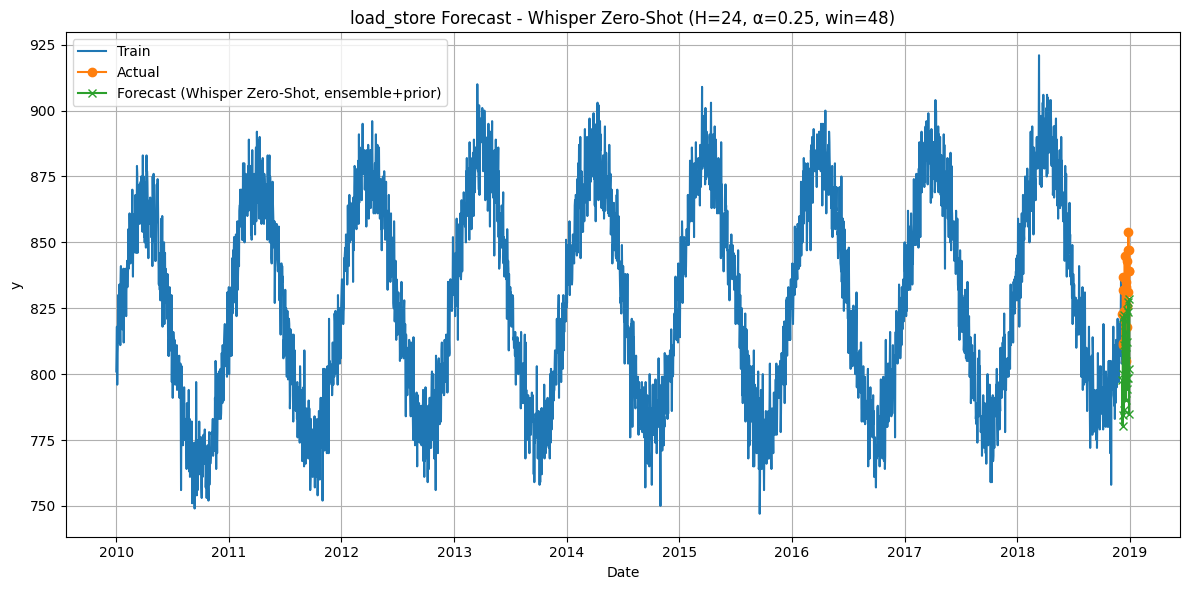

{'load_air_passengers': {'horizon': 24,
  'MAE': 165.74,
  'RMSE': 173.81,
  'MAPE (%)': np.float32(36.25),
  'R²': np.float32(-4.417)},
 'load_air_sunsopts': {'horizon': 120,
  'MAE': 423.16,
  'RMSE': 477.02,
  'MAPE (%)': np.float32(14481.1),
  'R²': np.float32(-127.2336)},
 'load_temp': {'horizon': 240,
  'MAE': 12.12,
  'RMSE': 15.07,
  'MAPE (%)': np.float32(126.02),
  'R²': np.float32(-18.918)},
 'load_temperature': {'horizon': 24,
  'MAE': 4.55,
  'RMSE': 5.79,
  'MAPE (%)': np.float32(24.5),
  'R²': np.float32(0.3146)},
 'load_precipitation': {'horizon': 24,
  'MAE': 229.1,
  'RMSE': 406.67,
  'MAPE (%)': np.float32(248.94),
  'R²': np.float32(-0.1498)},
 'load_humidity': {'horizon': 24,
  'MAE': 4.06,
  'RMSE': 4.54,
  'MAPE (%)': np.float32(26.08),
  'R²': np.float32(-0.0414)},
 'load_relative_humidity': {'horizon': 24,
  'MAE': 16.91,
  'RMSE': 19.54,
  'MAPE (%)': np.float32(23.14),
  'R²': np.float32(-0.1582)},
 'load_birth': {'horizon': 24,
  'MAE': 8.21,
  'RMSE': 11.32

In [ ]:
def load_store(horizon=24, unique_id="AP1"):
    df = pd.read_csv("https://raw.githubusercontent.com/ahamed14051/time-series-dataset/refs/heads/main/store.csv")
    df = df[(df['store'] == 0) & (df['product'] == 0)]
    df = df.drop(columns=['store', 'product'])

    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

    # Drop rows with invalid dates (like the description text)
    df = df.dropna(subset=['Date'])

    # Rename columns
    df = df.rename(columns={"Date": "ds", "number_sold": "y"})

    # Convert 'y' to numeric, coercing errors to NaN and dropping them
    df['y'] = pd.to_numeric(df['y'], errors='coerce')
    df = df.dropna(subset=['y'])

    print('Mean:', df['y'].mean())
    print(df.shape)

    # Train/test split
    train_df = df.iloc[:-horizon].copy()
    test_df = df.iloc[-horizon:].copy()

    # Add unique_id
    train_df['unique_id'] = unique_id
    test_df['unique_id'] = unique_id

    return train_df[['unique_id', 'ds', 'y']], test_df[['unique_id', 'ds', 'y']]

whisper_zeroshot_prediction(
    load_store,
    horizon=24,
    frequency="M",
    window_size=48,
    waveform_seconds=4,
    seed_list=(3,7,19,23,29,31,37,41),
    pooling_list=("mean","last"),
    alpha=0.25,
    log_transform=True,
    clamp_factor=1.5,
    verbose=True,
)

Mean: 1452.5068965517241
(348, 2)
[Zero-shot Whisper ENS] load_hospitality | H=24 | MAE=265.14 RMSE=275.20 MAPE=13.48% R²=-54.3022 | α=0.25 win=48 secs=4 seeds×pool=8×2


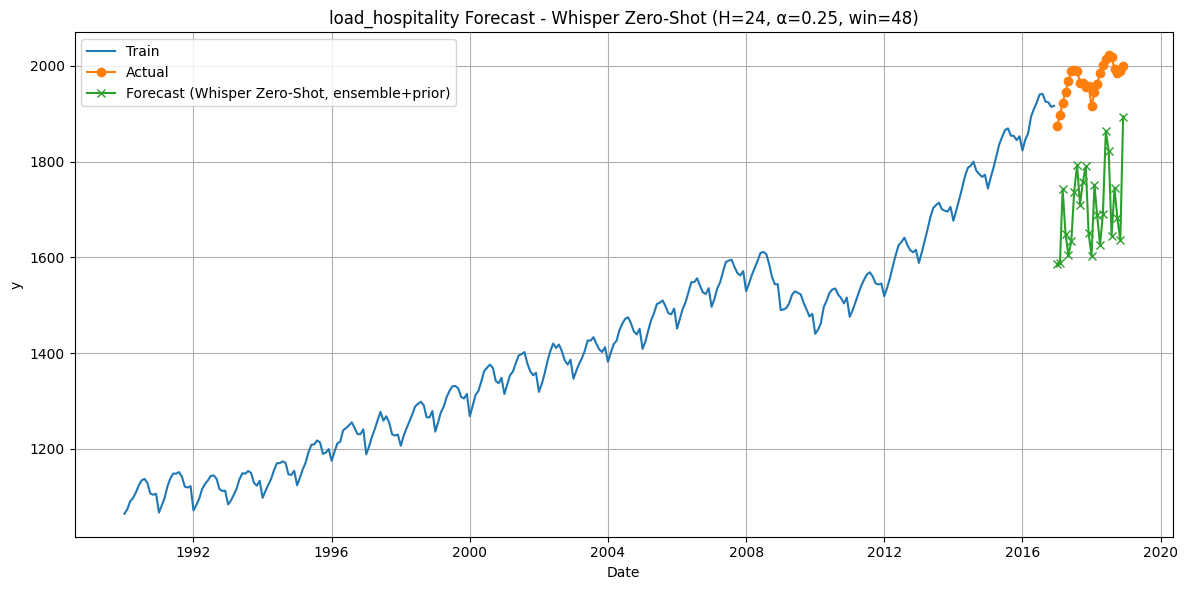

{'load_air_passengers': {'horizon': 24,
  'MAE': 165.74,
  'RMSE': 173.81,
  'MAPE (%)': np.float32(36.25),
  'R²': np.float32(-4.417)},
 'load_air_sunsopts': {'horizon': 120,
  'MAE': 423.16,
  'RMSE': 477.02,
  'MAPE (%)': np.float32(14481.1),
  'R²': np.float32(-127.2336)},
 'load_temp': {'horizon': 240,
  'MAE': 12.12,
  'RMSE': 15.07,
  'MAPE (%)': np.float32(126.02),
  'R²': np.float32(-18.918)},
 'load_temperature': {'horizon': 24,
  'MAE': 4.55,
  'RMSE': 5.79,
  'MAPE (%)': np.float32(24.5),
  'R²': np.float32(0.3146)},
 'load_precipitation': {'horizon': 24,
  'MAE': 229.1,
  'RMSE': 406.67,
  'MAPE (%)': np.float32(248.94),
  'R²': np.float32(-0.1498)},
 'load_humidity': {'horizon': 24,
  'MAE': 4.06,
  'RMSE': 4.54,
  'MAPE (%)': np.float32(26.08),
  'R²': np.float32(-0.0414)},
 'load_relative_humidity': {'horizon': 24,
  'MAE': 16.91,
  'RMSE': 19.54,
  'MAPE (%)': np.float32(23.14),
  'R²': np.float32(-0.1582)},
 'load_birth': {'horizon': 24,
  'MAE': 8.21,
  'RMSE': 11.32

In [ ]:
def load_hospitality(horizon=24, unique_id="AP1"):
    df = pd.read_csv("https://raw.githubusercontent.com/ahamed14051/time-series-dataset/refs/heads/main/HospitalityEmployees.csv")

    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

    # Drop rows with invalid dates (like the description text)
    df = df.dropna(subset=['Date'])

    # Rename columns
    df = df.rename(columns={"Date": "ds", "Employees": "y"})

    # Convert 'y' to numeric, coercing errors to NaN and dropping them
    df['y'] = pd.to_numeric(df['y'], errors='coerce')
    df = df.dropna(subset=['y'])

    print('Mean:', df['y'].mean())
    print(df.shape)

    # Train/test split
    train_df = df.iloc[:-horizon].copy()
    test_df = df.iloc[-horizon:].copy()

    # Add unique_id
    train_df['unique_id'] = unique_id
    test_df['unique_id'] = unique_id

    return train_df[['unique_id', 'ds', 'y']], test_df[['unique_id', 'ds', 'y']]

whisper_zeroshot_prediction(
    load_hospitality,
    horizon=24,
    frequency="M",
    window_size=48,
    waveform_seconds=4,
    seed_list=(3,7,19,23,29,31,37,41),
    pooling_list=("mean","last"),
    alpha=0.25,
    log_transform=True,
    clamp_factor=1.5,
    verbose=True,
)

In [ ]:
whisper_results = pd.DataFrame(RESULTS).T
whisper_results.to_csv('whisper_results.csv', index=True)
whisper_results

,horizon,MAE,RMSE,MAPE (%),R²
load_air_passengers,24.0,165.74,173.81,36.250000,-4.417000
load_air_sunsopts,120.0,423.16,477.02,14481.099609,-127.233597
load_temp,240.0,12.12,15.07,126.019997,-18.917999
load_temperature,24.0,4.55,5.79,24.500000,0.314600
load_precipitation,24.0,229.10,406.67,248.940002,-0.149800
load_humidity,24.0,4.06,4.54,26.080000,-0.041400
load_relative_humidity,24.0,16.91,19.54,23.139999,-0.158200
load_birth,24.0,8.21,11.32,17.299999,-2.203500
load_store,24.0,25.08,29.43,3.010000,-4.923100
load_hospitality,24.0,265.14,275.20,13.480000,-54.302200
